City Neighborhood Classifier 

CS 305: Machine Learning Fall 2021

Sara Clark, Christine Pourheydarian, Jiawei Liu


In [246]:
!pip3 install kaggle

In [247]:
import numpy as np
import pandas as pd
import csv
import random
random.seed(42)

In [248]:
'''
importing the calendar.csv data. 
listing id stays a number
date is kept in its form but has the dashes removed
available: if f, then becomes 0. if t, then becomes 1. 
price: converted from currency to a double. if there is no price, the value inserted is None. 
'''


from re import sub
from decimal import Decimal


calendar_csvfile = open('archive/calendar.csv', 'r')#listing_id,date,available,price
reader = csv.reader(calendar_csvfile, delimiter=',', quotechar='"')
calendar_data = []

for row in reader: 
    r  = [ ]
    for i in range(4):
        if i == 0:
            date = (row[1]).replace("-", "")
            r.append(date)
        elif i == 1:
            available = 0 if row[2] == "f" else 1 #f: 0, t: 1 
            r.append(available)
        elif i == 2:        
            money = row[3]
            if money == "":
                r.append(None)
                continue
            else: 
                value = float(Decimal(sub(r'[^\d.]', '', money)))#remove dollar sign, comma, and everything after the .
                r.append(value)
        elif i == 3: 
            listing_id  = int(row[0])
            r.append(listing_id)    
    calendar_data.append(r)


calendar_data_np = np.array(calendar_data)
print(calendar_data_np)

[['20170905' 0 None 12147973]
 ['20170904' 0 None 12147973]
 ['20170903' 0 None 12147973]
 ...
 ['20160908' 0 None 14504422]
 ['20160907' 0 None 14504422]
 ['20160906' 0 None 14504422]]


In [249]:
'''
Loading reviews.csv into numpy w/o any modification, i.e. w/o switching anything from qualitative to quantitative  
'''
from collections import defaultdict
csv_file = open('archive/reviews.csv', 'r')
reader = csv.reader(csv_file, delimiter=',', quotechar='"')
review_columns = []
data = []
reviews_and_ids = defaultdict(list) #key: listing id --> value: all comments corresponding to that listing id
for i, row in enumerate(reader):
    if i == 0:
        review_columns = row
        continue
    r = []
    for i in range(6):
        r.append(row[i])
    
    listing_id, review_text = row[0], row[-1]
    reviews_and_ids[listing_id].append(review_text)
    data.append(r)

csv_file.close()
reviews = np.array(data)
# print("reviews columns:\n", review_columns)
# print("reviews data:\n", reviews)

all_reviews = [ ] #list of reviews 
#each element of the corpus corresponds to all reviews of one listing concatenated together
for listing_id, reviews in reviews_and_ids.items():
    reviews_combined = "".join(reviews)
    reviews_combined = reviews_combined.replace("\n", "") #remove unnecessary characters
    all_reviews.append(reviews_combined)

In [250]:
# listings = np.loadtxt('archive/listings.csv', delimiter=',', skiprows = 1)
'''
but leaving out rows that dont have a value for host_neighborhood  and/or neighborhood 

'''
from re import sub
from decimal import Decimal


listings_csvfile = open('archive/listings.csv', 'r') 
reader = csv.reader(listings_csvfile, delimiter=',', quotechar='"')
listings_data = []
column = None 
property_types = {'': 0, 'Condominium': 1, 'Camper/RV': 2, 'House': 3, 'Townhouse': 4, 'Entire Floor': 5, 
              'Guesthouse': 6, 'Boat': 7, 'Dorm': 8, 'Villa': 9, 'Bed & Breakfast': 10, 'Other': 11, 'Apartment': 12, 
              'Loft': 13 }

room_types = {'Private room': 0, 'Shared room': 1, 'Entire home/apt': 2}
beds = {'Couch': 0, 'Airbed':1, 'Pull-out Sofa':2, 'Real Bed':3, 'Futon':4}
calendar_updated = {'never': 0, 'yesterday': 1, 'today': 2, '2 days ago': 3, '3 days ago': 4,
                    '4 days ago': 5, '5 days ago': 6, '6 days ago': 7, 'a week ago': 8, '1 week ago': 9,
                    '2 weeks ago': 10, '3 weeks ago': 11,'4 weeks ago': 12, '5 weeks ago': 13, '6 weeks ago': 14, 
                    '7 weeks ago': 15,'2 months ago': 16,'3 months ago': 17,'4 months ago': 18,'5 months ago': 19,
                    '7 months ago': 20,'6 months ago': 21, '8 months ago': 22,'9 months ago': 23,'10 months ago':24,
                    '11 months ago':25,'12 months ago':26, '13 months ago': 27, '14 months ago': 28, '15 months ago': 29, '16 months ago': 30, 
                    '17 months ago': 31, '18 months ago': 32, '20 months ago': 33, '22 months ago': 34, '30 months ago': 35, 
                    '23 months ago': 36, '25 months ago': 37 }
cancellation_policy = {'flexible': 0, 'moderate': 1, 'strict': 2, 'super_strict_30': 3}
indicesSet = set([0,19,32,33,48,49,53,54,55,56,59,65, \
                  67,68,71,72,73,74,76,79,80,81,82,83,84,85,93,94,50,86,89,91,92,51,52,57,\
                 60,61,62,63,64,66,69,90]) #columns included in the numpy array 
neighborhoods = [ ]
neighborhoodMatch = {} #a dictionary that maps a listing to a neighborhood tag in form "listing_id:neighborhood"
textFeatures = set()
listing_columns = [ ]
for index, row in enumerate(reader): 
    if index == 0:
        listing_columns = row
        continue
    #removing rows without a listed neighborhood in either of these 4 columns that correspond to neighborhood
    host_neighbourhood = row[31]
    neighbourhood = row[38]
    neighbourhood_cleansed = row[39]
    neighbourhood_group_cleansed = row[40]
    
    listing_id = row[0]

    if not neighbourhood and not host_neighbourhood \
        and not neighbourhood_cleansed and not neighbourhood_group_cleansed:
        continue 
    #adding neighborhood from whatever column it's stored in
    if neighbourhood: 
        neighborhoods.append(neighbourhood)
        neighborhoodMatch[listing_id]=neighbourhood
    elif neighbourhood_cleansed:
        neighborhoods.append(neighbourhood_cleansed)
        neighborhoodMatch[listing_id]=neighbourhood_cleansed
    elif neighbourhood_group_cleansed:
        neighborhoods.append(neighbourhood_group_cleansed)
        neighborhoodMatch[listing_id]=neighbourhood_group_cleansed
        
        

    if index == 0:
        columns = row
    r  = [ ] #row values
    for i in range(95): #i is a column index 
        if index == 0 and i in indicesSet: #then this is the header column names
            r.append(row[i])
        elif i == 0 or i == 19 or i == 32 or i == 33 \
            or i == 48 or i == 49 or i == 53 or i == 54 or i == 55 or i == 56 or i == 59 \
            or i == 65 or i == 67 or i == 68 or (i >=71 and i <= 74) or i == 76 or (i >= 79 \
            and i <= 85) or i ==  93 or i == 94: #listing id, host id 
            if row[i] == "N/A" or row[i] == "":
                r.append(None)
                continue 
            else:
                val = row[i] 
                r.append(val)
        elif i == 50 or i == 86 or i == 89 or i == 91 or i == 92:
            if row[i] == "N/A" or row[i] == "":
                r.append(-1)
                continue 
            else:
                boolean = 0 if row[i] == "f" else 1 
                r.append(boolean)
        elif i == 51:
            if row[i] == "N/A" or row[i] == "":
                r.append(-1)
                continue 
            else:
                property_type = property_types[row[i]]
                r.append(property_type)
        elif i == 52:
            if row[i] == "N/A" or row[i] == "":
                r.append(-1)
                continue 
            else:
                room_type = room_types[row[i]] 
                r.append(room_type)
        elif i == 57:
            if row[i] == "N/A" or row[i] == "":
                r.append(-1)
                continue 
            else:
                bed = row[i]
                r.append(beds[bed])
        elif (i >=  60 and i <= 64) or i == 66: 
            if row[i] == "N/A" or row[i] == "":
                r.append(-1)
                continue 
            else:
                money = row[i]
                value = float(Decimal(sub(r'[^\d.]', '', money)))#remove dollar sign, comma, and everything after the .
                r.append(value)
        elif i == 69: #calendar_updated col 
            if row[i] == "N/A" or row[i] == "":
                r.append(-1)
                continue 
            else:
                date = row[i]
                r.append(calendar_updated[date])  
        elif i == 90:
            if row[i] == "N/A" or row[i] == "":
                r.append(-1)
                continue 
            else:
                policy = row[i]
                val = cancellation_policy[(policy)] 
                r.append(val)
        elif i == 4 or i == 5 or i == 6 or i == 7 or i== 9 or i == 10 or i== 11 or i == 12 or i== 13 or i== 14 or i == 24 or i == 51 or i == 52 or i == 58: 
            if row[i] == "N/A" or row[i] == "":
                r.append("N/A")
                textFeatures.add(len(r))
                continue 
            else: 
                text = row[i]
                textFeatures.add(len(r))
                r.append(text)
    #get all reviews associated with the listing and then add them in the last column as one giant string
    listing_id = str(row[0])
    if listing_id in reviews_and_ids:
        reviews = reviews_and_ids[listing_id]
        blob_of_reviews = "".join(reviews)
    else:
        blob_of_reviews = ""
    r.append(blob_of_reviews)
    textFeatures.add(len(r)-1)
    listings_data.append(r)

listings_numerical_data = np.array(listings_data)
neighborhoods = np.array(neighborhoods)
allLabels, labelsCounts = np.unique(neighborhoods, return_counts=True)
print(textFeatures)
print("listings data \n", listings_numerical_data[:1,:]) #first row
print(listings_numerical_data.shape)
# print("listing_columns\n", listing_columns)
# print("listings data \n", listings_numerical_data[:5,:]) #first 5 rows
# print("neighborhoods data \n", neighborhoods)
# print("neighborhoods & listing matching \n", list(neighborhoodMatch.items())[:5])
textFeatures = set({1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 56, 25})

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 56, 25}
listings data 
 [['12147973' 'Sunny Bungalow in the City'
  'Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation.'
  'The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure.'
  "Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  

In [251]:
# #change None's to -1 and change numerical values in string form to floats
# for row_index, row in enumerate(listings_numerical_data): 
#     for col_index, element in enumerate(row):
#         if element is None:
#             listings_numerical_data[row_index, col_index] = -1
#             continue 
            
#         try:
#             listings_numerical_data[row_index, col_index] = float(element)
#         except ValueError:
#             continue 

In [252]:
print("listings data \n", listings_numerical_data[:1,:]) #first row

listings data 
 [['12147973' 'Sunny Bungalow in the City'
  'Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation.'
  'The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure.'
  "Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Fr

total # neighborhoods 
 23
Allston-Brighton Count : 432
Back Bay Count : 330
Beacon Hill Count : 210
Brookline Count : 12
Cambridge/Somerville Count : 22
Charlestown Count : 98
Chinatown Count : 84
Dorchester Count : 260
Downtown Count : 83
East Boston Count : 149
Fenway/Kenmore Count : 293
Hyde Park Count : 32
Jamaica Plain Count : 343
Mattapan Count : 28
Mission Hill Count : 122
North End Count : 145
Roslindale Count : 56
Roxbury Count : 148
South Boston Count : 258
South End Count : 330
Theater District Count : 34
West End Count : 74
West Roxbury Count : 42


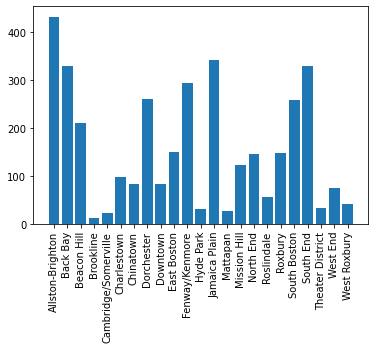

In [253]:
import matplotlib.pyplot as plt

#CONSOLIDATE BOSTON NEIGHBORHOODS
for count, neighborhood in enumerate(neighborhoods):
    if neighborhood in ['Cambridge','Harvard Square', 'Somerville']:
        neighborhoods[count] = "Cambridge/Somerville"
    elif neighborhood in ['Allston','Brighton']:
        neighborhoods[count] = "Allston-Brighton"
    elif neighborhood in ['Fenway', 'Longwood Medical Area']:
        neighborhoods[count] = "Fenway/Kenmore"
    elif neighborhood in ['Downtown Crossing','Government Center', 'Financial District', 'Leather District']:
        neighborhoods[count] = "Downtown"
    elif neighborhood == 'Bay Village':
        neighborhoods[count] = "Theater District"
    elif neighborhood == 'Chestnut Hill':
        neighborhoods[count] = "Brookline"
    elif neighborhood == 'South Boston Waterfront':
        neighborhoods[count] = "South Boston"
allLabels, labelsCounts = np.unique(neighborhoods, return_counts=True)
print("total # neighborhoods \n", len(allLabels) )
indices = np.arange(1,labelsCounts.shape[0]+1)
plt.xticks(rotation=90)
plt.bar(indices, labelsCounts, width=0.8, tick_label=allLabels)
for i in range(labelsCounts.shape[0]):
    print(allLabels[i], "Count :", labelsCounts[i])

<H3>Split Data By Neighborhood and Recombine (SARA) <H3>

In [254]:
from functools import reduce 
#1. Divide data by neighborhood
dividedData = [None] * len(allLabels)
for count, label in enumerate(allLabels):
    filter_arr = []
    for i, neighborhood in enumerate(neighborhoods):
        if neighborhood == label:
            filter_arr.append(listings_numerical_data[i])
    dividedData[count] = np.array(filter_arr)
#Randomly permute each row of a given neighborhood
    random.shuffle(dividedData[count])


In [255]:
    
# Split into Training and Testing
trainPercentage = 0.60
validationPercentage= 0.15
testPercentage= 0.25
trainX = []
testX = []
validationX = []
trainY = []
validationY = []
testY = []

#Split and recombine neighborhoods
for i in range(len(dividedData)):
    trainSize = int(len(dividedData[i])*trainPercentage)
    validationSize = int(len(dividedData[i])*validationPercentage)
    testSize = len(dividedData[i])- trainSize - validationSize
    print(allLabels[i],trainSize,validationSize, testSize)
    trainX.append(dividedData[i][:trainSize])
    trainY = trainY + ([allLabels[i]]*trainSize)
    
    validationX.append(dividedData[i][trainSize:trainSize+validationSize])
    validationY = validationY + ([allLabels[i]]*validationSize)
    
    testX.append(dividedData[i][trainSize+validationSize:])
    testY = testY + ([allLabels[i]]*testSize)
    
#Reformat Arrays
trainX = np.array(trainX, dtype='object')
trainX = np.concatenate(trainX)
validationX = np.array(validationX, dtype='object')
validationX = np.concatenate(validationX)
testX = np.array(testX, dtype='object')
testX = np.concatenate(testX)
trainY = np.array(trainY)
validationY = np.array(validationY)
testY = np.array(testY)
print(trainX.shape)
print(trainX[0:5])

Allston-Brighton 259 64 109
Back Bay 198 49 83
Beacon Hill 126 31 53
Brookline 7 1 4
Cambridge/Somerville 13 3 6
Charlestown 58 14 26
Chinatown 50 12 22
Dorchester 156 39 65
Downtown 49 12 22
East Boston 89 22 38
Fenway/Kenmore 175 43 75
Hyde Park 19 4 9
Jamaica Plain 205 51 87
Mattapan 16 4 8
Mission Hill 73 18 31
North End 87 21 37
Roslindale 33 8 15
Roxbury 88 22 38
South Boston 154 38 66
South End 198 49 83
Theater District 20 5 9
West End 44 11 19
West Roxbury 25 6 11
(2142, 57)
[['12184433' 'Private Room for You'
  '23 winship, brighton Room 6 Private room for you. Come, feel like home.'
  'N/A'
  '23 winship, brighton Room 6 Private room for you. Come, feel like home.'
  'N/A' 'N/A' 'N/A' 'N/A' 'N/A' 'N/A' '65476280' 'N/A' '1' '1'
  '42.34907817058224' '-71.15260510699403' 1 12 0 '1' '1.0' '1' '1' 3
  '{Internet,"Wireless Internet","Air Conditioning","Smoking Allowed","Pets Allowed","Family/Kid Friendly"}'
  None 999.0 -1 -1 -1 -1 '1' 0.0 '1' '1125' 19 '30' '60' '90' '365' '0'
 

<H3>Divide train/validation/text Data into numerical & text (JIAWEI)<H3>

In [274]:
#1.Get the columns with non-text features
numFeatures = set();
for i in range(57):
    if i not in textFeatures:
        numFeatures.add(i)
print(numFeatures)

#2.Create num/text holder for seperated train, validation, text data
numTrainX = np.empty((trainX.shape[0],len(numFeatures)),dtype=object)
textTrainX = np.empty((trainX.shape[0],len(textFeatures)),dtype=object)
numValidationX = np.empty((validationX.shape[0],len(numFeatures)),dtype=object)
textValidationX = np.empty((validationX.shape[0],len(textFeatures)),dtype=object)
numTestX = np.empty((testX.shape[0],len(numFeatures)),dtype=object)
textTestX = np.empty((testX.shape[0],len(textFeatures)),dtype=object)

print(textTrainX.shape)
print(numTrainX.shape)

{0, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55}
(2142, 13)
(2142, 44)


In [275]:
#3.Fill the newly created arrays with respected data from Sara's processed train/test/validation
for index,element in enumerate(textFeatures):
    for i in range(trainX.shape[0]): 
        textTrainX[i, index] = trainX[i,element]
    for j in range(validationX.shape[0]): 
        textValidationX[j, index] = validationX[j,element]
    for k in range(testX.shape[0]): 
        textTestX[k, index] = testX[k,element]
        
for index,element in enumerate(numFeatures):
    for i in range(trainX.shape[0]): 
        numTrainX[i, index] = trainX[i,element]
    for j in range(validationX.shape[0]): 
        numValidationX[j, index] = validationX[j,element]
    for k in range(testX.shape[0]): 
        numTestX[k, index] = testX[k,element]

In [276]:
#change None's to -1 and change numerical values in string form to floats(only in num DATA)
def toNum(data):
    for row_index, row in enumerate(data): 
        for col_index, element in enumerate(row):
            if element is None:
                data[row_index, col_index] = -1
                continue 

            try:
                data[row_index, col_index] = float(element)
            except ValueError:
                continue 

toNum(numTrainX)
toNum(numValidationX)
toNum(numTestX)

In [277]:
print(textTrainX.shape)
print(textTrainX[0:2])
print("Validation Shape: ",textValidationX.shape)
print(textValidationX[0:2])
print(textTestX[0:2])

print(numTrainX.shape)
print(numTrainX[0:2])
print(numValidationX[0:2])
print(numTestX[0:2])

(2142, 13)
[['Private Room for You'
  '23 winship, brighton Room 6 Private room for you. Come, feel like home.'
  'N/A'
  '23 winship, brighton Room 6 Private room for you. Come, feel like home.'
  'N/A' 'N/A' 'N/A' 'N/A' 'N/A' 'N/A' 'N/A' ''
  '{Internet,"Wireless Internet","Air Conditioning","Smoking Allowed","Pets Allowed","Family/Kid Friendly"}']
 ['Private Room for You'
  '23 winship, brighton Room 6 Private room for you. Come, feel like home.'
  'N/A'
  '23 winship, brighton Room 6 Private room for you. Come, feel like home.'
  'N/A' 'N/A' 'N/A' 'N/A' 'N/A' 'N/A' 'N/A' ''
  '{Internet,"Wireless Internet","Air Conditioning","Smoking Allowed","Pets Allowed","Family/Kid Friendly"}']]
Validation Shape:  (527, 13)
[['Sunny apt. available - 2 rooms'
  'Our apartment has a proper bedroom, a bright and spacious living room, a kitchen, and a separate bathroom. You will have it all by yourself!'
  "Hi! We live in a brownstone apartment with two large rooms, a nice kitchen, and small but cl

<H3>Text Analysis<H3>

- Remove neighborhood names from text-based feature columns used for training
- Bag of words: tfid vectorization
- Link reviews to correct neighborhood


In [260]:
# remove numbers from text reviews
from string import digits

def stripnumbers(string):
    return string.translate({ord(k): None for k in digits})


In [261]:
# make corpus and labels for ith column
labels_train = trainY
labels_validation = validationY

def makeCorpus(i):
    corpus_train = []
    corpus_validation = []
    for string in textTrainX[:,i]:
        corpus_train.append(stripnumbers(string))
    for string in textValidationX[:,i]:
        corpus_validation.append(stripnumbers(string))
    return (corpus_train,corpus_validation)


In [262]:
# Text feature extraction for training data, validation data, producing a vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

y_train = np.array(labels_train)
y_validation = np.array(labels_validation)

def makeVectorizer(i):
    corpus_train,corpus_validation = makeCorpus(i)
    vectorizer = TfidfVectorizer(min_df=1)  # Use individual words as tokens 
    textX_train = vectorizer.fit_transform(corpus_train).toarray()
    textX_validation = vectorizer.transform(corpus_validation).toarray()
#     print(corpus_train[0:5])
    return (vectorizer,textX_train,textX_validation)



In [263]:
#features and their weights
def printVectorizerFeatures(i):
    vectorizer,textX_train,textX_validation = makeVectorizer(i)
    print(vectorizer.get_feature_names())
    print(vectorizer.idf_)

In [264]:
printVectorizerFeatures(5)

['able', 'about', 'above', 'absolutely', 'ac', 'academic', 'accept', 'access', 'accessed', 'accessibility', 'accessible', 'accessing', 'accessories', 'accommodate', 'accommodated', 'accommodating', 'accommodations', 'accomodate', 'accordingly', 'account', 'accountants', 'accounts', 'accoutrements', 'across', 'act', 'activated', 'active', 'actual', 'actually', 'ad', 'add', 'added', 'adding', 'addition', 'additional', 'address', 'addresses', 'adhere', 'adjacent', 'adult', 'adults', 'advance', 'adventures', 'advise', 'affair', 'affordable', 'after', 'afternoon', 'again', 'ahead', 'aid', 'air', 'airbnb', 'airplanes', 'airport', 'airy', 'aka', 'all', 'allergic', 'allergies', 'allergy', 'allow', 'allowed', 'allows', 'allston', 'almond', 'almost', 'along', 'already', 'also', 'alternate', 'alternative', 'although', 'always', 'alzheimer', 'am', 'amenities', 'amo', 'among', 'amount', 'ample', 'amtrak', 'an', 'and', 'andrew', 'angled', 'animals', 'another', 'antenna', 'anticipate', 'antiques', 'a

In [265]:
from collections import Counter

def getMostCommon(aList):
    c = Counter(aList)
    value,count = c.most_common()[0]
    return value

In [267]:
#Make a matrix for final ensembling, will fill with 13*4 predictions from text, and 4 predictions from numerical
ensembleMtx = np.empty((textValidationX.shape[0],4),dtype=object)

In [268]:
%%time
# Use different classifiers to predict neighborhood label
from sklearn import linear_model  # Using sklearn Perceptron classifier
from sklearn import ensemble  # Using RandomForest classifier
from sklearn import neighbors  # Using nearest neighbors classifier
from sklearn.tree import DecisionTreeClassifier # Using Decision Tree classifier
from sklearn.svm import SVC # Using SVM classifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score



learners = {'Perceptron': linear_model.Perceptron(max_iter=10),
            'RandomForest': ensemble.RandomForestClassifier(),
            'DecisionTree': DecisionTreeClassifier(random_state=0),
#             'kNN': neighbors.KNeighborsClassifier(),
            'Logistic Regression': LogisticRegression(multi_class='multinomial', class_weight="balanced"),
#             'SVM': SVC(),
           }


for classifierName in learners:
    #Make a matrix to hold the prediction values based on each column of text feature
    predictionMtx = np.empty(textValidationX.shape,dtype=object)
    
    for i in range(textTrainX.shape[1]):
        vectorizer,textX_train,textX_validation = makeVectorizer(i)
        learners[classifierName].fit(textX_train, y_train)
        
        # record the prediction for ith column
        prediction = learners[classifierName].predict(textX_validation)
        # fill in the ith column of prediction matrix
        predictionMtx[:,i] = prediction
    
    # fill in ensemble Matrix
    ensembleMtx=np.concatenate((ensembleMtx,predictionMtx),axis=1) 
        
    # make a 1 column matrix to hold the final prediction labels
    finalPredict = np.empty(y_validation.shape[0],dtype=object)
    for i in range(predictionMtx.shape[0]): 
        finalPredict[i] = getMostCommon(list(predictionMtx[i]))
        

    print('Score Accuracy of ' + classifierName + ':\t' + str(accuracy_score(y_validation, finalPredict)))
#     print('Recall Score of ' + classifierName + ':\t' + str(recall_score(y_validation, finalPredict, average=None)))
#     print('Precision Score of ' + classifierName + ':\t' + str(precision_score(y_validation, finalPredict, average=None)))
#     print('Fi Score of ' + classifierName + ':\t' + str(f1_score(y_validation, finalPredict, average=None)))
#     print('\n')
#     print('Predicted Labels of '+ classifierName + ":\t" + finalPredict)
    
print(ensembleMtx.shape)
    

/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

Score Accuracy of Perceptron:	0.7628083491461101
Score Accuracy of RandomForest:	0.6755218216318786
Score Accuracy of DecisionTree:	0.6261859582542695
Score Accuracy of Logistic Regression:	0.6261859582542695
(527, 56)
CPU times: user 3min 32s, sys: 4.35 s, total: 3min 37s
Wall time: 2min 29s


In [236]:
print(ensembleMtx[0])

[None None None None 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'South End' 'Beacon Hill'
 'South End' 'Beacon Hill' 'Beacon Hill' 'Dorchester' 'Allston-Brighton'
 'Allston-Brighton' 'Jamaica Plain' 'Allston-Brighton' 'Allston-Brighton'
 'Brookline' 'Allston-Brighton' 'East Boston' 'Theater District'
 'Brookline' 'Brookline' 'Brookline' 'Allston-Brighton' 'South Boston'
 'Cambridge/Somerville' 'East Boston']


<H3>Numerical Data Analysis<H3>

In [229]:
from sklearn.preprocessing import StandardScaler
def scaleData(trainX, testX):
    scaler = StandardScaler()
    scaler.fit(trainX)
    return scaler.transform(trainX), scaler.transform(testX)

numTrainX, numValidationX = scaleData(numTrainX, numValidationX)

In [239]:
%%time
# Use different classifiers to predict neighborhood label
from sklearn import linear_model  # Using sklearn Perceptron classifier
from sklearn import ensemble  # Using RandomForest classifier
from sklearn import neighbors  # Using nearest neighbors classifier
from sklearn.tree import DecisionTreeClassifier # Using Decision Tree classifier
from sklearn.svm import SVC # Using SVM classifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

learnersList = [
            ('RandomForest', ensemble.RandomForestClassifier()),
            ('DecisionTree', DecisionTreeClassifier(random_state=0)),
            ('Logistic Regression', LogisticRegression(multi_class='multinomial', class_weight="balanced")),
            ('SVM', SVC())
           ]

for i in range(len(learnersList)):
    learnersList[i][1].fit(numTrainX,trainY)
    predicted = learnersList[i][1].predict(numValidationX)
    
    #fill in the ensemble Matrix
    ensembleMtx[:,i] = predicted
    
    print('Score Accuracy of ' + learnersList[i][0] + ':\t' + str(accuracy_score(validationY, predicted)))
    print('Recall Score of ' + learnersList[i][0] + ':\t' + str(recall_score(validationY, predicted, average=None)))
    print('Precision Score of ' + learnersList[i][0] + ':\t' + str(precision_score(validationY, predicted, average=None)))
    print('Fi Score of ' + learnersList[i][0] + ':\t' + str(f1_score(validationY, predicted, average=None)))
    print('\n')

Score Accuracy of RandomForest:	0.8823529411764706
Recall Score of RandomForest:	[0.984375   0.89795918 1.         0.         0.66666667 0.64285714
 0.66666667 1.         0.41666667 1.         0.86046512 0.75
 1.         0.         0.77777778 0.9047619  1.         0.77272727
 0.84210526 0.93877551 0.4        0.72727273 0.83333333]
Precision Score of RandomForest:	[1.         0.74576271 0.775      0.         1.         0.9
 1.         0.88636364 0.83333333 0.78571429 0.86046512 1.
 0.92727273 0.         0.93333333 0.82608696 0.88888889 0.85
 0.94117647 0.92       1.         1.         1.        ]
Fi Score of RandomForest:	[0.99212598 0.81481481 0.87323944 0.         0.8        0.75
 0.8        0.93975904 0.55555556 0.88       0.86046512 0.85714286
 0.96226415 0.         0.84848485 0.86363636 0.94117647 0.80952381
 0.88888889 0.92929293 0.57142857 0.84210526 0.90909091]


Score Accuracy of DecisionTree:	0.9449715370018975
Recall Score of DecisionTree:	[0.984375   0.97959184 1.         0.

/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

Score Accuracy of Logistic Regression:	0.7058823529411765
Recall Score of Logistic Regression:	[0.953125   0.46938776 0.64516129 0.         1.         0.85714286
 0.41666667 0.87179487 0.5        0.86363636 0.74418605 0.75
 0.64705882 0.         0.66666667 0.61904762 0.875      0.5
 0.78947368 0.73469388 0.4        0.54545455 0.66666667]
Precision Score of Logistic Regression:	[1.         0.6969697  0.66666667 0.         0.375      0.70588235
 0.26315789 0.85       0.42857143 0.9047619  0.72727273 0.27272727
 0.84615385 0.         0.52173913 0.65       0.53846154 0.44
 0.96774194 0.8        0.2        0.54545455 1.        ]
Fi Score of Logistic Regression:	[0.976      0.56097561 0.6557377  0.         0.54545455 0.77419355
 0.32258065 0.86075949 0.46153846 0.88372093 0.73563218 0.4
 0.73333333 0.         0.58536585 0.63414634 0.66666667 0.46808511
 0.86956522 0.76595745 0.26666667 0.54545455 0.8       ]


Score Accuracy of SVM:	0.6375711574952562
Recall Score of SVM:	[0.953125   0.67346

/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [240]:
print(ensembleMtx[0])

['Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'South End' 'Beacon Hill'
 'South End' 'Beacon Hill' 'Beacon Hill' 'Dorchester' 'Allston-Brighton'
 'Allston-Brighton' 'Jamaica Plain' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Fenway/Kenmore' 'Fenway/Kenmore'
 'Jamaica Plain' 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Fenway/Kenmore' 'Allston-Brighton' 'Jamaica Plain'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Brookline' 'Allston-Brighton'
 'East Boston' 'Theater District' 'Brookline' 'Brookline' 'Brookline'
 'Allston-Brighton' 'South Boston' 'Cambridge/Somerville' 'East Boston']


In [241]:
# make a 1 column matrix to hold the eventual prediction labels
eventualPredict = np.empty(y_validation.shape[0],dtype=object)
for i in range(ensembleMtx.shape[0]): 
    eventualPredict[i] = getMostCommon(list(ensembleMtx[i]))

In [242]:
# measure accuracy of ensembled prediction of text & numerical
print('Score Accuracy of ensembled' + ':\t' + str(accuracy_score(validationY, eventualPredict)))
print('Recall Score of ensembled'  + ':\t' + str(recall_score(validationY, eventualPredict, average=None)))
print('Precision Score of ensembled' + ':\t' + str(precision_score(validationY, eventualPredict, average=None)))
print('Fi Score of ensembled' + ':\t' + str(f1_score(validationY, eventualPredict, average=None)))

Score Accuracy of ensembled:	0.8311195445920304
Recall Score of ensembled:	[0.984375   0.85714286 1.         0.         0.66666667 0.78571429
 0.75       0.76923077 0.41666667 0.90909091 0.79069767 0.75
 0.92156863 0.         0.5        0.95238095 0.75       0.68181818
 0.73684211 1.         0.4        0.72727273 0.66666667]
Precision Score of ensembled:	[0.525      0.95454545 0.86111111 0.         1.         1.
 1.         0.90909091 0.83333333 1.         0.97142857 1.
 0.78333333 0.         1.         1.         1.         0.9375
 0.96551724 0.90740741 1.         1.         1.        ]
Fi Score of ensembled:	[0.68478261 0.90322581 0.92537313 0.         0.8        0.88
 0.85714286 0.83333333 0.55555556 0.95238095 0.87179487 0.85714286
 0.84684685 0.         0.66666667 0.97560976 0.85714286 0.78947368
 0.8358209  0.95145631 0.57142857 0.84210526 0.8       ]


/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h2>Final Evaluation on Testing Data<h2>

In [278]:
# make corpus and labels for ith column
labels_train = trainY
labels_validation = validationY

def makeTestCorpus(i):
    corpus_train = []
    corpus_test = []
    for string in textTrainX[:,i]:
        corpus_train.append(stripnumbers(string))
    for string in textTestX[:,i]:
        corpus_test.append(stripnumbers(string))
    return (corpus_train,corpus_test)


In [279]:
# Text feature extraction for training data, validation data, producing a vectorizer

def makeTestVectorizer(i):
    corpus_train,corpus_test = makeTestCorpus(i)
    vectorizer = TfidfVectorizer(min_df=1)  # Use individual words as tokens 
    textX_train = vectorizer.fit_transform(corpus_train).toarray()
    textX_test = vectorizer.transform(corpus_test).toarray()
#     print(corpus_train[0:5])
    return (vectorizer,textX_train,textX_test)



In [280]:
#Make a matrix for final ensembling, will fill with textfeature*4 predictions from text, and 4 predictions from numerical
TestEnsembleMtx = np.empty((textTestX.shape[0],4),dtype=object)

In [281]:
for classifierName in learners:
    #Make a matrix to hold the prediction values based on each column of text feature
    TestpredictionMtx = np.empty(textTestX.shape,dtype=object)
    
    for i in range(textTrainX.shape[1]):
        vectorizer,textX_train,textX_test = makeTestVectorizer(i)
        learners[classifierName].fit(textX_train, y_train)
        
        # record the prediction for ith column
        prediction = learners[classifierName].predict(textX_test)
        # fill in the ith column of prediction matrix
        TestpredictionMtx[:,i] = prediction
    
    # fill in ensemble Matrix
    TestEnsembleMtx=np.concatenate((TestEnsembleMtx,TestpredictionMtx),axis=1) 
        
    # make a 1 column matrix to hold the final prediction labels
    TestfinalPredict = np.empty(testY.shape[0],dtype=object)
    for i in range(TestpredictionMtx.shape[0]): 
        TestfinalPredict[i] = getMostCommon(list(TestpredictionMtx[i]))
        

    print('Score Accuracy of ' + classifierName + ':\t' + str(accuracy_score(testY, TestfinalPredict)))
#     print('Recall Score of ' + classifierName + ':\t' + str(recall_score(y_validation, finalPredict, average=None)))
#     print('Precision Score of ' + classifierName + ':\t' + str(precision_score(y_validation, finalPredict, average=None)))
#     print('Fi Score of ' + classifierName + ':\t' + str(f1_score(y_validation, finalPredict, average=None)))
#     print('\n')
#     print('Predicted Labels of '+ classifierName + ":\t" + finalPredict)
    
print(TestEnsembleMtx.shape)

/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

Score Accuracy of Perceptron:	0.7554585152838428
Score Accuracy of RandomForest:	0.618995633187773
Score Accuracy of DecisionTree:	0.6048034934497817
Score Accuracy of Logistic Regression:	0.6080786026200873
(916, 56)


In [282]:
numTrainX, numTestX = scaleData(numTrainX, numTestX)

In [284]:
for i in range(len(learnersList)):
    learnersList[i][1].fit(numTrainX,trainY)
    predicted = learnersList[i][1].predict(numTestX)
    
    #fill in the ensemble Matrix
    TestEnsembleMtx[:,i] = predicted
    
    print('Score Accuracy of ' + learnersList[i][0] + ':\t' + str(accuracy_score(testY, predicted)))
    print('Recall Score of ' + learnersList[i][0] + ':\t' + str(recall_score(testY, predicted, average=None)))
    print('Precision Score of ' + learnersList[i][0] + ':\t' + str(precision_score(testY, predicted, average=None)))
    print('Fi Score of ' + learnersList[i][0] + ':\t' + str(f1_score(testY, predicted, average=None)))


Score Accuracy of RandomForest:	0.8657205240174672
Recall Score of RandomForest:	[0.96330275 0.92771084 0.98113208 0.5        0.5        0.88461538
 0.59090909 1.         0.40909091 0.92105263 0.92       0.55555556
 1.         0.5        0.77419355 0.97297297 0.46666667 0.63157895
 0.8030303  0.90361446 0.55555556 0.63157895 0.72727273]
Precision Score of RandomForest:	[0.95454545 0.77777778 0.8        1.         1.         1.
 0.8125     0.92857143 1.         0.83333333 0.85185185 1.
 0.84466019 1.         0.96       0.7826087  0.875      0.92307692
 0.98148148 0.76530612 0.83333333 1.         0.88888889]
Fi Score of RandomForest:	[0.95890411 0.84615385 0.88135593 0.66666667 0.66666667 0.93877551
 0.68421053 0.96296296 0.58064516 0.875      0.88461538 0.71428571
 0.91578947 0.66666667 0.85714286 0.86746988 0.60869565 0.75
 0.88333333 0.82872928 0.66666667 0.77419355 0.8       ]
Score Accuracy of DecisionTree:	0.9410480349344978
Recall Score of DecisionTree:	[0.89908257 0.93975904 0.96

/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score Accuracy of SVM:	0.5895196506550219
Recall Score of SVM:	[0.96330275 0.5060241  0.47169811 0.25       0.33333333 0.42307692
 0.04545455 0.76923077 0.13636364 0.71052632 0.65333333 0.33333333
 0.93103448 0.125      0.32258065 0.54054054 0.33333333 0.39473684
 0.57575758 0.51807229 0.         0.21052632 0.36363636]
Precision Score of SVM:	[0.96330275 0.39252336 0.35714286 1.         1.         0.64705882
 0.33333333 0.76923077 0.5        0.9        0.56321839 1.
 0.68644068 1.         1.         0.58823529 0.41666667 0.39473684
 0.48101266 0.38392857 0.         0.5        1.        ]
Fi Score of SVM:	[0.96330275 0.44210526 0.40650407 0.4        0.5        0.51162791
 0.08       0.76923077 0.21428571 0.79411765 0.60493827 0.5
 0.7902439  0.22222222 0.48780488 0.56338028 0.37037037 0.39473684
 0.52413793 0.44102564 0.         0.2962963  0.53333333]


/Users/jwl/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [285]:
print(TestEnsembleMtx[0])

['Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Mattapan' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton' 'West End'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton' 'Brookline'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton' 'Allston-Brighton'
 'Allston-Brighton' 'Allston-Brighton'

In [287]:
# make a 1 column matrix to hold the eventual prediction labels
TesteventualPredict = np.empty(testY.shape[0],dtype=object)
for i in range(TestEnsembleMtx.shape[0]): 
    TesteventualPredict[i] = getMostCommon(list(TestEnsembleMtx[i]))

In [288]:
# measure accuracy of ensembled prediction of text & numerical
print("On Test Data:")
print('Score Accuracy of ensembled' + ':\t' + str(accuracy_score(testY, TesteventualPredict)))
print('Recall Score of ensembled'  + ':\t' + str(recall_score(testY, TesteventualPredict, average=None)))
print('Precision Score of ensembled' + ':\t' + str(precision_score(testY, TesteventualPredict, average=None)))
print('Fi Score of ensembled' + ':\t' + str(f1_score(testY, TesteventualPredict, average=None)))

On Test Data:
Score Accuracy of ensembled:	0.7620087336244541
Recall Score of ensembled:	[1.         0.80722892 0.9245283  0.5        0.5        0.73076923
 0.59090909 0.73846154 0.31818182 0.73684211 0.81333333 0.44444444
 0.90804598 0.5        0.41935484 0.91891892 0.53333333 0.5
 0.65151515 0.79518072 0.55555556 0.57894737 0.54545455]
Precision Score of ensembled:	[0.41444867 0.93055556 0.9245283  1.         0.75       1.
 1.         1.         0.7        1.         1.         1.
 0.73148148 1.         0.92857143 0.91891892 0.88888889 1.
 0.93478261 0.83544304 1.         0.91666667 1.        ]
Fi Score of ensembled:	[0.58602151 0.86451613 0.9245283  0.66666667 0.6        0.84444444
 0.74285714 0.84955752 0.4375     0.84848485 0.89705882 0.61538462
 0.81025641 0.66666667 0.57777778 0.91891892 0.66666667 0.66666667
 0.76785714 0.81481481 0.71428571 0.70967742 0.70588235]


<h2>Attempted code for reference<h3>

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorizeText(i):
    #Vectorize an individual column
    corpus_train = trainX[:, i]
    corpus_validate = validationX[:,i]
    vectorizer = TfidfVectorizer(min_df=5, max_features=1000)  # Use individual words as tokens
    textX_train = vectorizer.fit_transform(corpus_train).toarray()
    textX_validate = vectorizer.transform(corpus_validate).toarray()
    print(i)
    print(vectorizer.get_feature_names())
    print(vectorizer.idf_)
    return np.array(textX_train), np.array(textX_validate)
    
for i in sorted(textFeatures): # for each text based column that requires vectorization
    corpus_train = []
    corpus_validate = []
    trainVectorized, validateVectorized = vectorizeText(i)
    for j in range(trainX.shape[0]): #replace text value with vectorized text in training data
        trainX[j, i] = trainVectorized[i]
    for j in range(validationX.shape[0]): #replace text value with vectorized text in validation data
        validationX[j, i] = validateVectorized[i]
# print(trainX[0,:]) 
# print(trainX[0,:])
final_trainX = [None] * trainX.shape[0]
for i in range(trainX.shape[0]):
    final_trainX[i]=np.concatenate(trainX[i,:], axis=None)
final_trainX = np.array(final_trainX, dtype='float64')
final_validationX = [None] * validationX.shape[0]
for i in range(validationX.shape[0]):
    final_validationX[i]=np.concatenate(validationX[i,:], axis=None)
# print(final_trainX[1])
final_validationX = np.array(final_validationX, dtype='float64')
# print(final_trainX[0,:])
print(final_trainX.shape)
print(final_validationX.shape)
print(final_trainX[0:5])

1
['10', '1125', '1246', '1247', '1250', '1293', '1330', '15', '1535', '155', '1684', '1852', '1857', '1b', '1bd', '1br', '1c', '2990', '2ba', '2bd', '2br', '2brs', '2c', '2nd', '3b', '3br', 'access', 'airbed', 'airport', 'airy', 'all', 'allston', 'amazing', 'and', 'apartment', 'apartments', 'apt', 'area', 'arlington', 'at', 'ave', 'avenue', 'away', 'awesome', 'ba', 'back', 'backbay', 'baker', 'bath', 'bathroom', 'baths', 'bay', 'bc', 'bd', 'bdr', 'bdrm', 'be', 'beach', 'beacon', 'beautiful', 'beauty', 'bed', 'bedroom', 'bedrooms', 'beds', 'best', 'between', 'beyond', 'blue', 'boston', 'br', 'brand', 'breakfast', 'bright', 'brighton', 'brookline', 'brownstone', 'bu', 'building', 'bunker', 'bus', 'business', 'by', 'cambridge', 'center', 'central', 'centrally', 'charles', 'charlestown', 'charm', 'charming', 'chic', 'chinatown', 'chocolate', 'circle', 'city', 'classic', 'clean', 'cleveland', 'close', 'colleges', 'columbus', 'come', 'comfort', 'comfortable', 'comfy', 'common', 'commonwealt

3
['10', '12', '14', '15', '150', '20', '24', '25', '2nd', '30', '39', '3rd', '40', '42', '4th', '50', '80', 'able', 'about', 'ac', 'access', 'accessible', 'accommodate', 'accommodates', 'accommodations', 'across', 'addition', 'additional', 'adjacent', 'adults', 'affordable', 'after', 'air', 'airbnb', 'airport', 'alcove', 'all', 'allows', 'along', 'also', 'alternative', 'always', 'am', 'amazing', 'amenities', 'amenity', 'among', 'ample', 'an', 'and', 'another', 'any', 'anything', 'anywhere', 'apartment', 'apartments', 'apple', 'appliances', 'appointed', 'apt', 'aquarium', 'arboretum', 'architecture', 'are', 'area', 'areas', 'arlington', 'arnold', 'around', 'arrival', 'art', 'as', 'ask', 'at', 'atmosphere', 'attractions', 'available', 'avenue', 'away', 'back', 'backyard', 'balconies', 'balcony', 'bar', 'bars', 'basement', 'basic', 'basics', 'basketball', 'bath', 'bathroom', 'bathrooms', 'baths', 'bathtub', 'bay', 'be', 'beacon', 'beautiful', 'beautifully', 'bed', 'bedding', 'bedroom', '

4
['10', '100', '12', '14', '15', '20', '24', '25', '2nd', '30', '39', '3rd', '40', '42', '50', 'able', 'about', 'above', 'ac', 'access', 'accessible', 'accommodate', 'accommodates', 'across', 'addition', 'additional', 'adjacent', 'adventurers', 'affordable', 'after', 'air', 'airbnb', 'airport', 'all', 'allows', 'along', 'also', 'alternative', 'always', 'am', 'amazing', 'ambiance', 'amenities', 'amenity', 'america', 'among', 'ample', 'an', 'and', 'another', 'answer', 'antique', 'any', 'anything', 'anywhere', 'apartment', 'apartments', 'apple', 'appliances', 'appointed', 'apt', 'aquarium', 'arboretum', 'are', 'area', 'areas', 'arlington', 'arnold', 'around', 'arrival', 'arrive', 'art', 'arts', 'as', 'ask', 'assist', 'at', 'attractions', 'available', 'ave', 'avenue', 'away', 'awesome', 'back', 'backyard', 'balconies', 'balcony', 'bar', 'bars', 'base', 'basement', 'basic', 'basketball', 'bath', 'bathroom', 'bathrooms', 'baths', 'bay', 'bc', 'be', 'beach', 'beacon', 'beautiful', 'beautiful

7
['00', '000', '10', '100', '10min', '12', '120', '13', '14', '15', '151', '16', '17', '18th', '197', '20', '20min', '217', '24', '25', '30', '300', '35', '36', '37', '38', '39', '40', '41', '43', '45', '47', '50', '51', '57', '5min', '64', '66', '6min', '72', '82', '86', '8am', '90', '93', 'able', 'about', 'above', 'access', 'accessed', 'accessible', 'across', 'action', 'actual', 'addition', 'adjacent', 'adjoining', 'affords', 'airport', 'airports', 'all', 'allow', 'allows', 'allston', 'almost', 'along', 'also', 'alternative', 'alternatively', 'although', 'always', 'am', 'amenities', 'america', 'among', 'ample', 'amtrak', 'an', 'and', 'andrew', 'another', 'antique', 'any', 'anyone', 'anything', 'anywhere', 'apartment', 'apartments', 'app', 'appliances', 'approx', 'approximately', 'aquarium', 'arch', 'are', 'area', 'areas', 'arlington', 'around', 'arrange', 'arrive', 'art', 'arts', 'as', 'ashmont', 'ask', 'at', 'attending', 'attention', 'attractions', 'attractive', 'authority', 'avail

[5.23597479 6.59052045 5.37412513 6.47273742 4.20405388 5.96191179
 6.10501264 4.46526938 4.37950255 5.37412513 5.53446778 6.10501264
 6.47273742 5.62543956 6.10501264 6.47273742 6.18505535 4.98108254
 6.27206672 6.72405185 5.96191179 5.08644306 5.03237584 6.59052045
 6.18505535 6.27206672 6.72405185 6.27206672 5.72552302 6.27206672
 6.27206672 6.03090467 6.47273742 5.11461393 5.96191179 4.66262881
 5.96191179 6.47273742 5.53446778 6.18505535 5.67422972 5.57891954
 6.3673769  6.59052045 5.77959024 6.72405185 6.72405185 5.11461393
 4.52682727 5.72552302 5.33775749 6.27206672 3.07897501 6.59052045
 6.47273742 6.27206672 5.33775749 5.62543956 4.88577236 5.89737327
 3.21037648 4.51107891 3.02098776 6.47273742 4.33922866 6.59052045
 5.57891954 4.0255711  6.18505535 3.98783077 1.94372859 5.72552302
 3.24501198 6.59052045 5.08644306 6.47273742 5.00640035 3.21892354
 4.8413206  6.59052045 5.14360147 5.77959024 5.49190817 6.59052045
 5.83674865 5.89737327 2.57865211 4.98108254 4.88577236 6.0309

25
['24', 'accessible', 'aid', 'air', 'allowed', 'bedroom', 'breakfast', 'building', 'buzzer', 'cable', 'carbon', 'card', 'cat', 'check', 'conditioning', 'detector', 'dog', 'door', 'doorman', 'dryer', 'elevator', 'en', 'essentials', 'events', 'extinguisher', 'family', 'fire', 'fireplace', 'first', 'for', 'free', 'friendly', 'gym', 'hair', 'hangers', 'heating', 'hosting_amenity_49', 'hosting_amenity_50', 'hot', 'hour', 'in', 'indoor', 'intercom', 'internet', 'iron', 'kid', 'kit', 'kitchen', 'laptop', 'live', 'lock', 'missing', 'monoxide', 'on', 'parking', 'pets', 'pool', 'premises', 'property', 'safety', 'shampoo', 'smoke', 'smoking', 'street', 'suitable', 'this', 'translation', 'tub', 'tv', 'washer', 'wheelchair', 'wireless', 'workspace']
[2.13617316 3.84164826 2.21005754 1.21408531 2.81202884 3.22322462
 3.499478   2.27972133 2.52792459 1.73167751 1.42216941 3.14850108
 3.93376355 2.13617316 1.21408531 1.25478689 3.72831957 3.22322462
 3.56401652 1.20030782 2.27972133 2.82352322 1.213

(2142, 11051)
(527, 11051)
[[12184433.        0.        0. ...        0.        0.        0.]
 [12184433.        0.        0. ...        0.        0.        0.]
 [13824970.        0.        0. ...        0.        0.        0.]
 [12184433.        0.        0. ...        0.        0.        0.]
 [13824970.        0.        0. ...        0.        0.        0.]]


In [42]:
# check for NaN
# array_sum = np.sum(final_trainX)
# array_has_nan = np.isnan(array_sum)
# print(array_has_nan)
final_trainX = np.where(final_trainX == None, final_trainX, -1)
array_sum = np.sum(final_trainX)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)
final_validationX = np.where(final_validationX == None, final_validationX, -1)
array_sum = np.sum(final_validationX)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

False
False


In [24]:
from sklearn.preprocessing import StandardScaler
print(trainX.shape)
scaler = StandardScaler()
scaler.fit_transform(trainX)
validationX = scaler.transform(validationX)

(2142, 57)


ValueError: could not convert string to float: 'Private Room for You'

In [16]:
%%time
# Use different classifiers to predict neighborhood label
from sklearn.metrics import f1_score
from sklearn import linear_model  # Using sklearn Perceptron classifier
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble  # Using RandomForest classifier
from sklearn import neighbors  # Using nearest neighbors classifier

learners = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', class_weight="balanced"),
            'Perceptron': linear_model.Perceptron(max_iter=10, class_weight="balanced"),
            'RandomForest': ensemble.RandomForestClassifier(class_weight="balanced"),
#             'RandomForest': ensemble.RandomForestClassifier(class_weight="balanced"),
            'kNN': neighbors.KNeighborsClassifier()
            
           }
for classifierName in learners:
    print(classifierName)
    learners[classifierName].fit(trainX, trainY)
    predicted = learners[classifierName].predict(validationX)
    print('Score Accuracy of ' + classifierName + ':\t' + str(learners[classifierName].score(validationX, validationY)))
    print('F1 Accuracy of ' + classifierName + ':\t' + str(f1_score(validationY, predicted, average=None)))
    

Logistic Regression


ValueError: setting an array element with a sequence.

Feature Scaling

In [ ]:
#split data. rows already randomly permuted

# Split data into training (80%) and testing (20%).
# Use feature scaling to standardize the features.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X = listings_numerical_data
y = neighborhoods

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

def scaleData(trainX, testX):
    scaler = StandardScaler()
    scaler.fit(trainX)
    return scaler.transform(trainX), scaler.transform(testX)

X_train, X_test = scaleData(X_train, X_test)

split into training and testing
- first organize stuff by neighborhood
- randomly permute rows of each neighborhood set
- then select 25% of each neighborhood for testing and the rest for training
- combine the testing components and the training components

- **** we also planned to do cross validation, but maybe we can revisit that later?


In [ ]:
# Split data into training (80%) and testing (20%) and randomly permute rows
# Use feature scaling to standardize the features.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
def scaleData(trainX, testX):
    scaler = StandardScaler()
    scaler.fit(trainX)
    return scaler.transform(trainX), scaler.transform(testX)

X_train, X_test = scaleData(X_train, X_test)

In [ ]:
# Cross validation

Create Classification models
- kNN
- random forest
- SVM
- Logistic Regression
- Neural Network (or Perceptron)




In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model  # Using sklearn Perceptron classifier
from sklearn import ensemble  # Using RandomForest classifier
from sklearn.svm import SVC

from sklearn import neighbors  # Using nearest neighbors classifier
# learners = {'Perceptron': linear_model.Perceptron(max_iter=10),
#             'RandomForest': ensemble.RandomForestClassifier(),
#             'kNN': neighbors.KNeighborsClassifier(),
#             'SVM': SVC(),
#             'LogisticRegression': linear_model.LogisticRegression(random_state=42)
#            },
           }
# for classifierName in learners:
#     learners[classifierName].fit(X_train, y_train)
#     print('Accuracy of ' + classifierName + ':\t' + str(learners[classifierName].score(X_test, y_test)))

In [ ]:
#Here is where Jiawei will do NN
# Get Perceptron weights
# learner = linear_model.Perceptron(max_iter=1)
learner.fit(X_train, y_train)
weights = learner.coef_  # Get the learned Perceptron weights
sorted_weights = np.argsort(weights)  # Sort
features = vectorizer.get_feature_names()  # Get the features
print('\nLowest weighted words (indicative of ham)')
for i in range(5): print(features[sorted_weights[0,i]])
print('\nHighest weighted words (indicative of spam)')
for i in range(5): print(features[sorted_weights[0,len(sorted_weights[0])-i-1]])

<h1>Testing<h1>

<h3>F1 Score</h3>

In [ ]:
# Train a sklearn Logistic Regression classifier on the scaled training data
# and report the F1 score of the classifier on the scaled testing data.

#from exercise 5 
from sklearn.linear_model import *
from sklearn.metrics import *


model = sklearn.linear_model.LogisticRegression().fit(X_train, y_train)
preds = model.predict(X_test)

sklearn.metrics.f1_score(y_test, preds)

<h3>Recall Score</h3>

In [ ]:
# Above you used default parameter settings for the SVM. 
# As in the previous task, let's explore different possible 
# values for the two parameters, C and gamma. For the C parameter, 
# experiment with the following six values: 0.01, 0.1, 1.0, 10.0, 100.0, and 1000.0. 
# For the gamma parameter, experiment with the following six values: 
# 0.001, 0.01, 0.1, 1.0, 10.0, 100.0. Try all 36 combinations of these two parameters.

# Evaluate the accuracy of the SVM when different values are used for parameters C and gamma.
# For parameter C, explore values of 0.01, 0.1, 1.0, 10.0, 100.0, and 1000.0
# For parameter gamma, explore values of 0.001, 0.01, 0.1, 1.0, 10.0, and 100.0 
#from exercise 7 
C = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
gamma = 0.001, 0.01, 0.1, 1.0, 10.0, 100.0
max_accuracy = 0 
max_c = 0 
max_gamma = 0 
for c in C: 
    for g in gamma: 
        clf = make_pipeline(StandardScaler(), SVC(C=c, gamma=g))
        clf.fit(X_train_pca, y_train)
        score = clf.score(X_test_pca, y_test)
        if score > max_accuracy: 
            max_accuracy = score
            max_c = c
            max_gamma = g

print('c', max_c)
print('gamma', max_gamma)

print('testing', max_accuracy)

clf = make_pipeline(StandardScaler(), SVC(C=max_c, gamma=max_gamma))
clf.fit(X_train_pca, y_train)
score = clf.score(X_train_pca, y_train)
print('training', score)

In [ ]:
# Using optimal values for parameters C and gamma,
# assess the precision, recall, and F1 score of the SVM on each class (person)

#from exercise 7 
from sklearn.metrics import classification_report
import sklearn.svm as svm
clf = svm.SVC(C = 10, gamma = .001)
clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=people))